In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import random
print(sys.version)
print(sys.executable)

3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]
F:\Anaconda3\envs\GNNInterpreter\python.exe


In [3]:
import torch

# Cyclicity

In [6]:
from GNNInterpreter.gnninterpreter.datasets.cyclicity_dataset import CyclicityDataset
from GNNInterpreter.gnninterpreter.models.nnconv_classifier import NNConvClassifier

In [7]:
dataset = CyclicityDataset(seed=12345)

data: Data(x=[84, 1], edge_index=[2, 168], edge_attr=[168, 2], y=[1], G=Graph with 84 nodes and 84 edges)
class: red_cyclic
data: Data(x=[57, 1], edge_index=[2, 112], edge_attr=[112, 2], y=[1], G=Graph with 57 nodes and 56 edges)
class: acyclic
data: Data(x=[74, 1], edge_index=[2, 148], edge_attr=[148, 2], y=[1], G=Graph with 74 nodes and 74 edges)
class: red_cyclic
data: Data(x=[30, 1], edge_index=[2, 60], edge_attr=[60, 2], y=[1], G=Graph with 30 nodes and 30 edges)
class: red_cyclic
data: Data(x=[12, 1], edge_index=[2, 24], edge_attr=[24, 2], y=[1], G=Graph with 12 nodes and 12 edges)
class: green_cyclic
data: Data(x=[72, 1], edge_index=[2, 144], edge_attr=[144, 2], y=[1], G=Graph with 72 nodes and 72 edges)
class: red_cyclic
data: Data(x=[83, 1], edge_index=[2, 166], edge_attr=[166, 2], y=[1], G=Graph with 83 nodes and 83 edges)
class: green_cyclic
data: Data(x=[27, 1], edge_index=[2, 54], edge_attr=[54, 2], y=[1], G=Graph with 27 nodes and 27 edges)
class: acyclic
data: Data(x=[23

11401

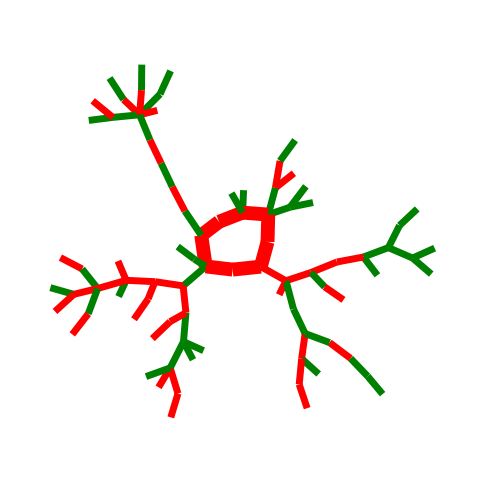

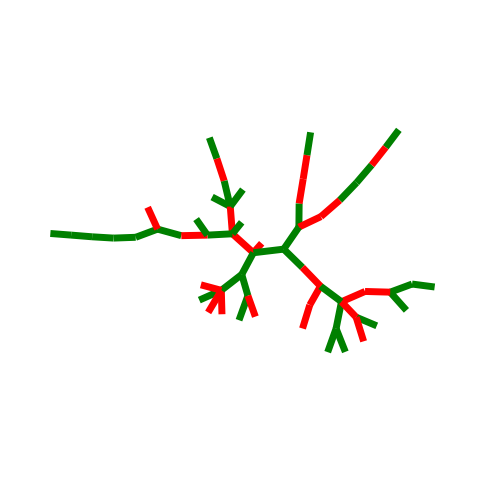

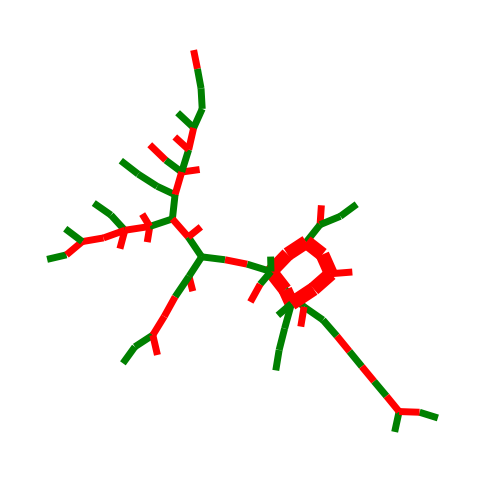

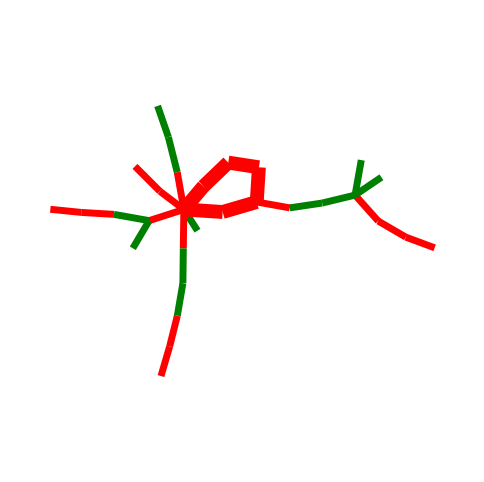

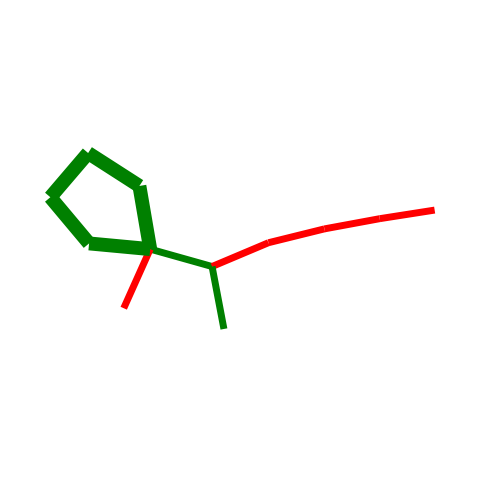

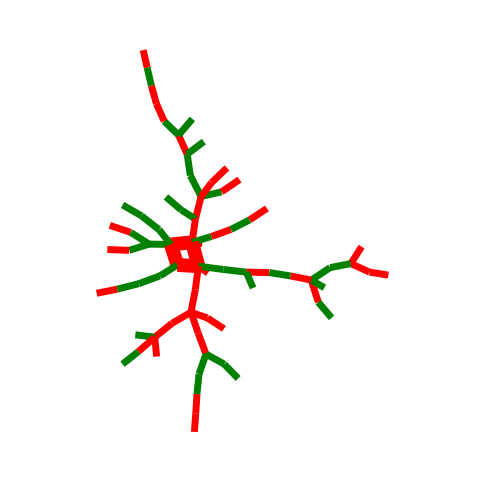

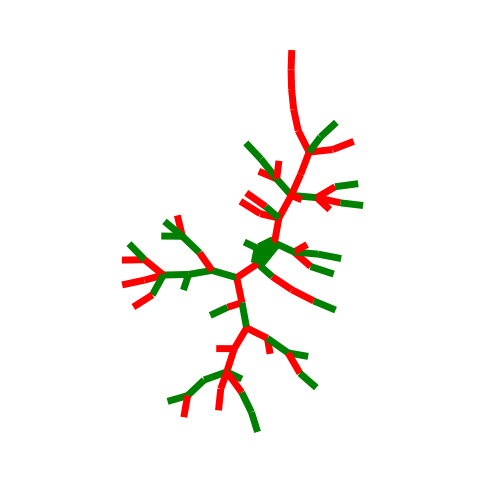

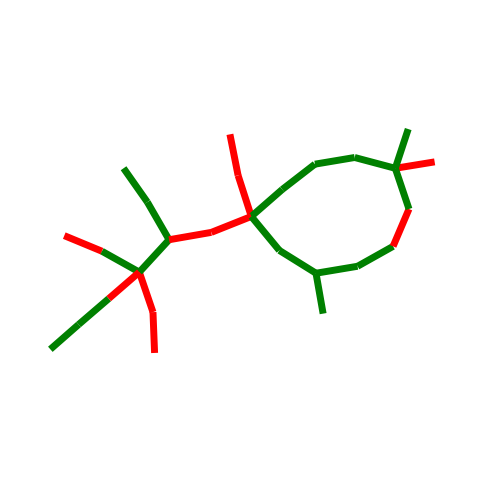

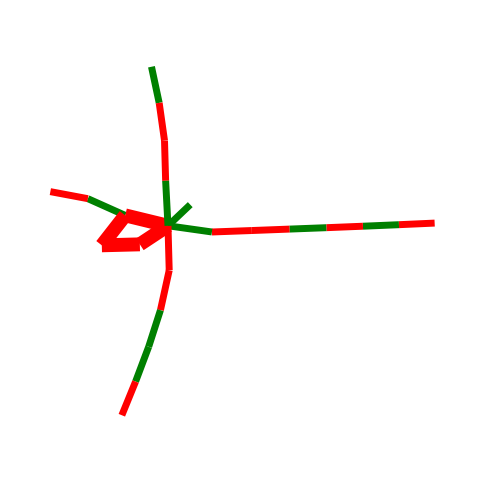

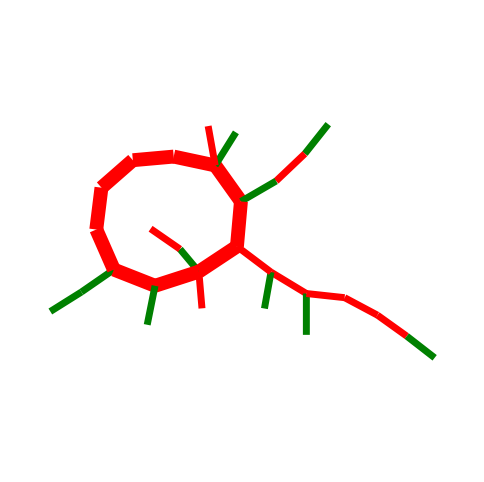

In [62]:
for i in random.sample(range(len(dataset)), 10):
    dataset.show(i)
    
dataset.len()

In [9]:
model = NNConvClassifier(node_features=len(dataset.NODE_CLS),
                         edge_features=len(dataset.EDGE_CLS),
                         num_classes=len(dataset.GRAPH_CLS),
                         hidden_channels=32)

In [10]:
model.load_state_dict(torch.load('ckpts/cyclicity.pt'))

<All keys matched successfully>

In [11]:
dataset.evaluate_model(model)

F:\Anaconda3\envs\GNNInterpreter\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


{'red_cyclic': 0.9747729301452637,
 'green_cyclic': 0.9551874399185181,
 'acyclic': 0.9634025692939758}

In [12]:
mean_embeds = dataset.mean_embeddings(model)

In [13]:
trainer = {}
sampler = {}

# Red Cyclic

In [68]:
from GNNInterpreter.gnninterpreter.regularizations.budget_penalty import BudgetPenalty
from GNNInterpreter.gnninterpreter.regularizations.kl_divergence_penalty import KLDivergencePenalty
from GNNInterpreter.gnninterpreter.regularizations.norm_penalty import NormPenalty
from GNNInterpreter.gnninterpreter.regularizations.mean_penalty import MeanPenalty
from GNNInterpreter.gnninterpreter.criteria.embedding_criterion import EmbeddingCriterion
from GNNInterpreter.gnninterpreter.criteria.class_score_criterion import ClassScoreCriterion
from GNNInterpreter.gnninterpreter.criteria.weighted_criterion import WeightedCriterion
from GNNInterpreter.gnninterpreter.graph_sampler import GraphSampler
from GNNInterpreter.gnninterpreter.trainer import Trainer

In [75]:
cls_idx = 0
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        num_edge_cls=len(dataset.EDGE_CLS),
        temperature=0.15,
        learn_node_feat=True,
        learn_edge_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=1),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=2),
        dict(key="omega", criterion=NormPenalty(order=2), weight=2),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=5),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=15, order=2, beta=1),
    target_probs={cls_idx: (0.9, 1)},
    k_samples=16
)

In [78]:
trainer[0].train(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

呼呼呼呼


True

n=4 m=5
logits=[107.29214477539062, -8.613713264465332, -2.997380018234253]
probs=[1.0, 0.0, 0.0]


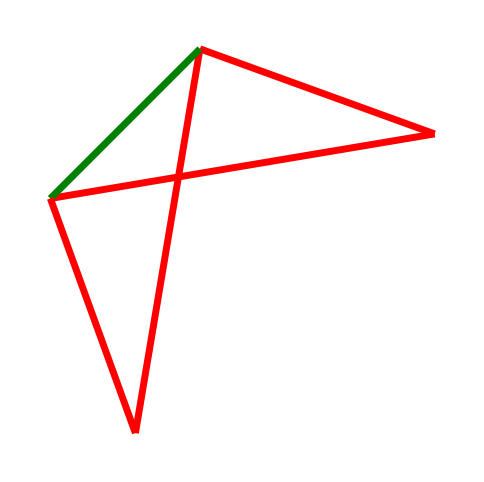

In [83]:
trainer[0].evaluate(threshold=0.5, connected=True, show=True)

# Green Cyclic

In [29]:
cls_idx = 1
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        num_edge_cls=len(dataset.EDGE_CLS),
        temperature=0.15,
        learn_node_feat=False,
        learn_edge_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=1),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=2),
        dict(key="omega", criterion=NormPenalty(order=2), weight=2),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=5),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=15, order=2, beta=1),
    target_probs={cls_idx: (0.9, 1)},
    k_samples=16
)

In [31]:
trainer[1].train(2000)

  4%|3         | 81/2081 [00:00<?, ?it/s]

呼呼呼呼


True

n=14 m=15
logits=[-2.293656587600708, 18.587318420410156, -1.8228349685668945]
probs=[8.540975149351482e-10, 1.0, 1.3676766386083727e-09]


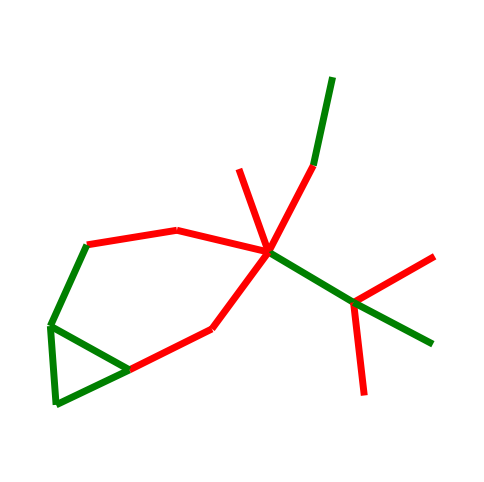

In [34]:
trainer[1].evaluate(threshold=0.5, show=True)

# Acyclic

In [35]:
cls_idx = 2
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        num_edge_cls=len(dataset.EDGE_CLS),
        temperature=0.15,
        learn_node_feat=False,
        learn_edge_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=1),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=2),
        dict(key="omega", criterion=NormPenalty(order=2), weight=2),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=5),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=15, order=2, beta=1),
    target_probs={cls_idx: (0.9, 1)},
    k_samples=16
)

In [36]:
trainer[2].train(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

False

n=20 m=72
logits=[-22377.796875, -4345.86669921875, -4906.07666015625]
probs=[0.0, 1.0, 0.0]


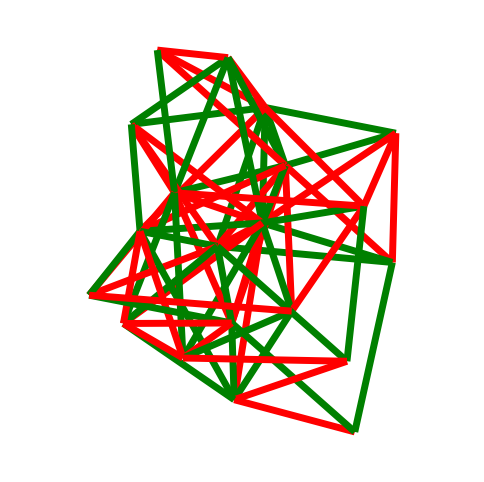

In [37]:
trainer[2].evaluate(threshold=0.5, show=True)